In [122]:
# ===========================================
# 0. 設定（環境・パス・選手名）
# ===========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# -------------------------------------------
# ターゲット選手を選ぶ（ここだけ変えればOK）
# -------------------------------------------
TARGET_PLAYER = "Kaoru YAMAWAKI"

# -------------------------------------------
# データパス設定（02_daily/players 以下を使う）
# -------------------------------------------
BASE = f"/workspace/data/02/players/{TARGET_PLAYER}/"

STATIC_PATH  = BASE + f"{TARGET_PLAYER}_static.parquet"
DYNAMIC_PATH = BASE + f"{TARGET_PLAYER}_dynamic.parquet"
ACWR_PATH    = BASE + f"{TARGET_PLAYER}_acwr.parquet"   # 必須ではないが使える

print("TARGET PLAYER:", TARGET_PLAYER)
print("Static path :", STATIC_PATH)
print("Dynamic path:", DYNAMIC_PATH)

# -------------------------------------------
# データロード
# -------------------------------------------
df_static = pd.read_parquet(STATIC_PATH)
df_dyn    = pd.read_parquet(DYNAMIC_PATH)

df_static = df_static.sort_values("date_").reset_index(drop=True)
df_dyn    = df_dyn.sort_values("date_").reset_index(drop=True)

print("Loaded static :", df_static.shape)
print("Loaded dynamic:", df_dyn.shape)


TARGET PLAYER: Kaoru YAMAWAKI
Static path : /workspace/data/02/players/Kaoru YAMAWAKI/Kaoru YAMAWAKI_static.parquet
Dynamic path: /workspace/data/02/players/Kaoru YAMAWAKI/Kaoru YAMAWAKI_dynamic.parquet
Loaded static : (623, 50)
Loaded dynamic: (623, 12)


In [123]:
# ===========================================
# 1. 静的データ準備
# ===========================================

# GK 専用列（Field Player 分析のため除外）
gk_cols = [
    "total_dive_load_centre", "total_dive_load_left", "total_dive_load_right",
    "dive_right_count", "dive_left_count", "dive_centre_count",
    "total_dives_centre", "total_dives_left", "total_dives_right",
    "total_time_to_feet_centre", "total_time_to_feet_left", "total_time_to_feet_right"
]

# 除外しない基礎列
exclude_base = ["athlete_name", "date_"] + gk_cols

# 静的特徴量の候補
static_cols_fp = [c for c in df_static.columns if c not in exclude_base]

# 作業用 DF
df_static_fp = df_static[ ["date_"] + static_cols_fp ].copy()

print("静的特徴量（FP用）:", len(static_cols_fp), "columns")

# 標準偏差 0 の列を除外
X_raw = df_static_fp.drop(columns=["date_"])
stds = X_raw.std()
non_zero_std_cols = stds[stds > 0].index.tolist()

print("標準偏差 > 0 の列数:", len(non_zero_std_cols))

# 最終的に使うデータ
X_static = X_raw[non_zero_std_cols].values

print("👉 静的データ準備完了")
print("X_static shape:", X_static.shape)


静的特徴量（FP用）: 36 columns
標準偏差 > 0 の列数: 35
👉 静的データ準備完了
X_static shape: (623, 35)


In [124]:
# ===========================================
# 2. 静的異常検知（Isolation Forest）
# ===========================================

# IsolationForest モデル
iso = IsolationForest(
    contamination=0.05,   # 異常日5%
    random_state=42
)

# 学習
iso_pred = iso.fit_predict(X_static)      # -1 = 異常
iso_score = iso.decision_function(X_static)  # スコア（低いほど異常）

# DataFrame に追加
df_static_fp["iso_score"] = iso_score
df_static_fp["iso_anomaly"] = (iso_pred == -1).astype(int)

print("異常日数:", df_static_fp["iso_anomaly"].sum())
print(df_static_fp.head())


異常日数: 32
       date_  session_duration_sec  total_duration  min_heart_rate  \
0 2023-01-12               8089.00         8089.00            88.0   
1 2023-01-13               4952.00         4952.00             0.0   
2 2023-01-14               6672.00         6672.00             0.0   
3 2023-01-16               6900.64         6900.64             0.0   
4 2023-01-17               5169.66         5169.66             0.0   

   velocity_band1_total_distance  velocity_band2_total_distance  \
0                     2586.79001                     3637.67002   
1                     2680.89000                     3394.86994   
2                     3486.83996                     4187.44994   
3                     3825.88004                     2508.10999   
4                     2269.78005                     3161.34000   

   velocity_band3_total_distance  gen2_velocity_band1_total_effort_count  \
0                      292.55000                                     0.0   
1              

In [125]:
# ===========================================
# 2.5 異常日のトップ特徴量（理由）の抽出関数
# ===========================================

# 標準化のための統計量
mean_vec = X_raw[non_zero_std_cols].mean()
std_vec  = X_raw[non_zero_std_cols].std()

def top_contributing_features(row, n=5):
    """
    1日の特徴量 row を受け取り、
    Z-score の絶対値が大きい上位 n 個を返す。
    """
    values = row[non_zero_std_cols]
    z = (values - mean_vec) / std_vec
    z_abs = z.abs()

    return z_abs.sort_values(ascending=False).head(n)


# 異常日の理由をリスト化する
anomaly_days = df_static_fp[df_static_fp["iso_anomaly"] == 1].copy()
anomaly_days["top_features"] = anomaly_days.apply(
    lambda row: top_contributing_features(row, n=5).index.tolist(),
    axis=1
)

print("異常日サンプル:")
display(anomaly_days[["date_", "top_features"]].head())


異常日サンプル:


,date_,top_features
8,2023-01-22,"[ima_band2_decel_count, ima_band3_decel_count,..."
13,2023-01-27,"[velocity2_band6_total_distance, velocity2_ban..."
16,2023-02-01,"[metabolic_power_band3_total_distance, gen2_ve..."
17,2023-02-02,"[velocity_band3_total_distance, metabolic_powe..."
21,2023-02-12,"[velocity2_band6_total_distance, velocity2_ban..."


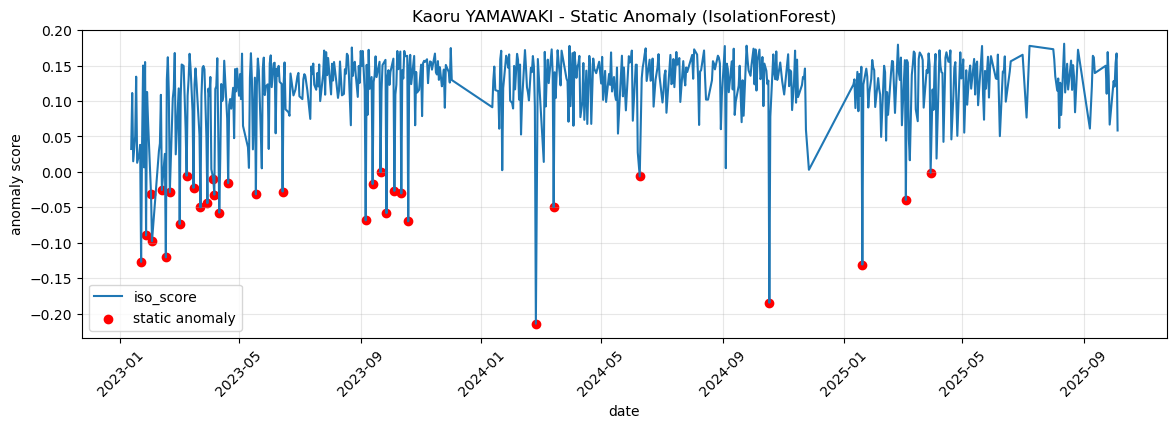

In [126]:
# ===========================================
# 2.6 静的異常スコアのミニ可視化（1枚だけ）
# ===========================================
plt.figure(figsize=(14,4))
plt.plot(df_static_fp["date_"], df_static_fp["iso_score"], label="iso_score")

# 異常日を赤く表示
anom_mask = df_static_fp["iso_anomaly"] == 1
plt.scatter(
    df_static_fp["date_"][anom_mask],
    df_static_fp["iso_score"][anom_mask],
    color="red",
    label="static anomaly"
)

plt.title(f"{TARGET_PLAYER} - Static Anomaly (IsolationForest)")
plt.xlabel("date")
plt.ylabel("anomaly score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [127]:
# ===========================================
# ★ 2.7 静的ラベルの保存
# ===========================================

save_static = df_static_fp[["date_", "iso_score", "iso_anomaly"]].copy()

# top_features（異常日のみ）
save_static = save_static.merge(
    anomaly_days[["date_", "top_features"]],
    on="date_",
    how="left"
)

SAVE_DIR = f"/workspace/data/03/players/{TARGET_PLAYER}"
os.makedirs(SAVE_DIR, exist_ok=True)

STATIC_LABEL_PATH = f"{SAVE_DIR}/static_labels.parquet"
save_static.to_parquet(STATIC_LABEL_PATH, index=False)

print("💾 Saved static labels →", STATIC_LABEL_PATH)


💾 Saved static labels → /workspace/data/03/players/Kaoru YAMAWAKI/static_labels.parquet


In [128]:
# ===========================================
# 3. 動的データ準備
# ===========================================

# 既にロード済み（df_dyn）
print("🔍 動的データ shape:", df_dyn.shape)

# 日付確認
df_dyn = df_dyn.sort_values("date_").reset_index(drop=True)

print("🔍 動的最初の5行:")
display(df_dyn.head())


🔍 動的データ shape: (623, 12)
🔍 動的最初の5行:


,athlete_name,date_,total_distance,total_player_load,max_vel,mean_heart_rate,max_heart_rate,heart_rate_band2_total_duration,heart_rate_band3_total_duration,velocity_band4_total_distance,velocity_band5_total_distance,velocity_band6_total_distance
0,Kaoru YAMAWAKI,2023-01-12,7601.84152,909.58697,28.49351,155.842712,195.0,1417.40001,2171.00004,291.52,494.92999,295.72001
1,Kaoru YAMAWAKI,2023-01-13,6962.62402,749.72084,30.56668,158.254888,189.0,45.90000,1741.00000,130.90,79.77000,238.53000
2,Kaoru YAMAWAKI,2023-01-14,9154.79894,1057.41031,31.08442,142.445105,192.0,1154.80002,2342.79998,289.56,99.93000,143.83000
3,Kaoru YAMAWAKI,2023-01-16,10961.83075,1083.33823,27.34162,124.967800,184.0,1981.49998,1600.30001,1943.47,1210.29006,302.02999
4,Kaoru YAMAWAKI,2023-01-17,6640.39460,707.63383,26.67819,82.781118,138.0,3020.09995,127.40000,323.88,169.95000,61.56000


In [129]:
# 動的特徴量の列（athlete_name を除く）
dynamic_feature_cols = [c for c in df_dyn.columns if c not in ["athlete_name", "date_"]]

X_dyn_raw = df_dyn[dynamic_feature_cols].astype(float).values
dates_dyn = df_dyn["date_"].values

print("動的特徴量数:", len(dynamic_feature_cols))
print("X_dyn_raw shape:", X_dyn_raw.shape)


動的特徴量数: 10
X_dyn_raw shape: (623, 10)


In [130]:
# ===========================================
# 3.3 スケーリング
# ===========================================
scaler_dyn = StandardScaler()
X_dyn_scaled = scaler_dyn.fit_transform(X_dyn_raw)

print("スケーリング後 shape:", X_dyn_scaled.shape)


スケーリング後 shape: (623, 10)


In [131]:
# ===========================================
# 3.4 シーケンス化（過去 SEQ_LEN 日, シーズン分割対応）
# ===========================================

SEQ_LEN = 30           # 窓幅
BREAK_DAYS = 30        # 30日以上空いたら別シーズン

# 日付差からシーズンブロックを定義
gap_days = df_dyn["date_"].diff().dt.days
season_block = (gap_days > BREAK_DAYS).cumsum().fillna(0).astype(int)
df_dyn["season_block"] = season_block

seq_list = []
seq_dates = []

for block_id in sorted(df_dyn["season_block"].unique()):
    # このブロックだけ取り出し
    mask = df_dyn["season_block"] == block_id
    X_block = X_dyn_scaled[mask]
    dates_block = dates_dyn[mask]

    if len(X_block) < SEQ_LEN:
        # 30日分たまってない短いブロックはスキップ
        continue

    # ブロック内で通常どおりシーケンス化
    for i in range(len(X_block) - SEQ_LEN + 1):
        seq_list.append(X_block[i:i+SEQ_LEN])
        seq_dates.append(dates_block[i + SEQ_LEN - 1])

seq_array = np.stack(seq_list)

print("シーケンス数:", len(seq_array))
print("シーケンス shape:", seq_array.shape)  # (num_seq, 30, features)



シーケンス数: 536
シーケンス shape: (536, 30, 10)


In [132]:
# ===========================================
# 3.5 PyTorch Dataset & DataLoader
# ===========================================

class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32)

dataset = SequenceDataset(seq_array)

# train : val = 7 : 3（時系列なので前半を train）
train_ratio = 0.7
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("train size:", len(train_dataset))
print("val   size:", len(val_dataset))


train size: 375
val   size: 161


In [133]:
# ===========================================
# 4. LSTM AutoEncoder モデル定義（安定版）
# ===========================================

class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32, num_layers=2, dropout=0.1):
        super().__init__()

        # ----- Encoder -----
        self.encoder_lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)

        # ----- Decoder -----
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            hidden_dim,
            input_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        enc_out, _ = self.encoder_lstm(x)
        h_last = enc_out[:, -1, :]                  # 最終ステップの隠れ状態
        z = self.encoder_fc(h_last)                 # latent vector

        # latent → decoder 初期値
        dec_init = self.decoder_fc(z).unsqueeze(1) # (batch, 1, hidden_dim)
        dec_init = dec_init.repeat(1, x.size(1), 1) # (batch, seq_len, hidden_dim)

        dec_out, _ = self.decoder_lstm(dec_init)    # (batch, seq_len, input_dim)
        return dec_out


In [134]:
# ===========================================
# 4.1 モデル初期化
# ===========================================

input_dim = X_dyn_scaled.shape[1]  # 動的特徴量数

model = LSTMAutoEncoder(
    input_dim=input_dim,
    hidden_dim=64,
    latent_dim=32,
    num_layers=2,
    dropout=0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("✅ Model ready on device:", device)


✅ Model ready on device: cpu


Epoch   1 | train: 0.990527 | val: 1.012461
Epoch   2 | train: 0.925917 | val: 0.919153
Epoch   3 | train: 0.857626 | val: 0.870411
Epoch   4 | train: 0.812491 | val: 0.837685
Epoch   5 | train: 0.788964 | val: 0.821502
Epoch   6 | train: 0.775526 | val: 0.810350
Epoch   7 | train: 0.765399 | val: 0.801628
Epoch   8 | train: 0.757659 | val: 0.795371
Epoch   9 | train: 0.751562 | val: 0.790060
Epoch  10 | train: 0.746807 | val: 0.785469
Epoch  11 | train: 0.742313 | val: 0.780046
Epoch  12 | train: 0.735639 | val: 0.771335
Epoch  13 | train: 0.726732 | val: 0.763629
Epoch  14 | train: 0.720176 | val: 0.757575
Epoch  15 | train: 0.714420 | val: 0.752395
Epoch  16 | train: 0.710214 | val: 0.748719
Epoch  17 | train: 0.706941 | val: 0.745043
Epoch  18 | train: 0.703542 | val: 0.741745
Epoch  19 | train: 0.700746 | val: 0.739616
Epoch  20 | train: 0.698599 | val: 0.738629
Epoch  21 | train: 0.697290 | val: 0.736286
Epoch  22 | train: 0.695707 | val: 0.734813
Epoch  23 | train: 0.694327 | va

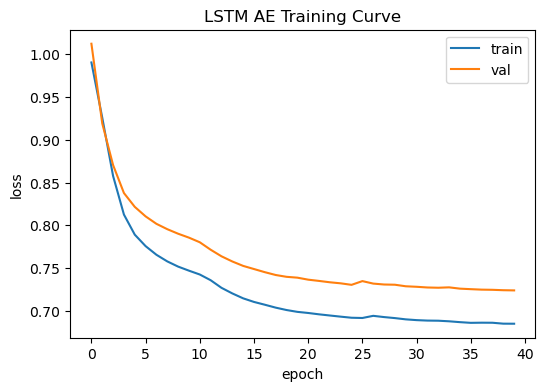

In [135]:
# ===========================================
# 4.2 学習ループ（安定）
# ===========================================

EPOCHS = 40

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_train = 0

    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * x.size(0)

    train_loss = total_train / len(train_dataset)
    val_loss   = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:3d} | train: {train_loss:.6f} | val: {val_loss:.6f}")

# 学習曲線
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("LSTM AE Training Curve")
plt.show()


In [136]:
# ===========================================
# 5. 全シーケンスの再構成誤差の計算
# ===========================================

model.eval()

all_errors = []
with torch.no_grad():
    for i in range(len(seq_array)):
        x = torch.tensor(seq_array[i:i+1], dtype=torch.float32).to(device)
        recon = model(x)
        err = ((recon - x)**2).mean().item()
        all_errors.append(err)

all_errors = np.array(all_errors)

print("📌 Reconstruction error stats:")
print(" mean:", all_errors.mean())
print(" std :", all_errors.std())


📌 Reconstruction error stats:
 mean: 0.6945963381831326
 std : 0.7515620115757642


In [137]:
threshold = all_errors.mean() + 3 * all_errors.std()
print("🔥 Dynamic anomaly threshold:", threshold)

dynamic_anomaly = (all_errors > threshold).astype(int)


🔥 Dynamic anomaly threshold: 2.9492823729104254


In [138]:
df_dyn_anom = pd.DataFrame({
    "date_": seq_dates,          # ← ここを date_list から変更
    "dyn_error": all_errors,
    "dyn_anomaly": dynamic_anomaly
})



In [139]:
SAVE_DIR_03 = f"/workspace/data/03/players/{TARGET_PLAYER}"
os.makedirs(SAVE_DIR_03, exist_ok=True)

OUTPUT_PATH = f"{SAVE_DIR_03}/dynamic_labels.parquet"
df_dyn_anom.to_parquet(OUTPUT_PATH, index=False)

print("💾 Saved dynamic labels →", OUTPUT_PATH)



💾 Saved dynamic labels → /workspace/data/03/players/Kaoru YAMAWAKI/dynamic_labels.parquet


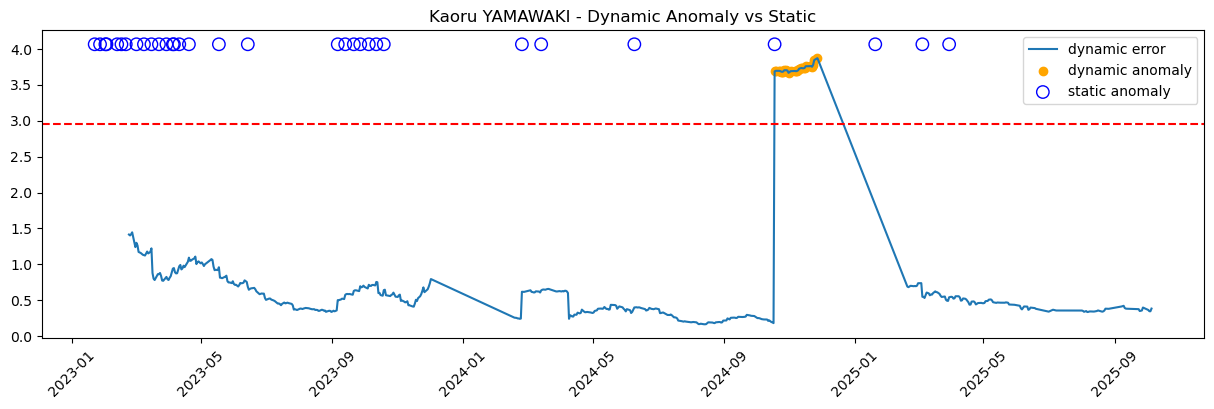

In [140]:
plt.figure(figsize=(15,4))
plt.plot(df_dyn_anom["date_"], df_dyn_anom["dyn_error"], label="dynamic error")
plt.axhline(threshold, color="red", linestyle="--")

mask_dyn = df_dyn_anom["dyn_anomaly"]==1
plt.scatter(df_dyn_anom["date_"][mask_dyn],
            df_dyn_anom["dyn_error"][mask_dyn],
            color="orange", label="dynamic anomaly")

# 静的異常を重ねたい場合（オプション）
plt.scatter(df_static_fp["date_"][df_static_fp["iso_anomaly"]==1],
            np.full(df_static_fp["iso_anomaly"].sum(), df_dyn_anom["dyn_error"].max()*1.05),
            edgecolors="blue", facecolors='none', s=80, label="static anomaly")

plt.title(f"{TARGET_PLAYER} - Dynamic Anomaly vs Static")
plt.xticks(rotation=45)
plt.legend()
plt.show()
